### Extension Plan - Analysis and Predictive Modeling

In part 1 of this project, we analyzed wildfire data across the US and created a smoke estimate to represent wildfire smoke exposure for the residents of Stockton, San Joaquin County, California. Additionally, we built a model to predict smoke estimates for Stockton from **2020-2050**.  

In notebook [6_health_data.ipynb](6_health_data.ipynb), we gathered, cleaned, and processed health data for San Joaquin County residents, specifically focusing on deaths and hospital discharges related to respiratory diseases over the years.  

In this notebook, we’ll analyze how smoke estimates impact health outcomes by examining the correlations with death and discharge data. We’ll also develop predictive models to estimate deaths using the smoke estimates generated in part 1.

### Preliminaries

Let’s begin by installing and importing the necessary packages to load data, visualize trends, and train models.

In [1]:
%%capture
%pip install matplotlib
%pip install statsmodels

In [2]:
# packages for data manipulation and plot generation
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

# packages for scaling and calculating correlation coefficients
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

### Retrieving Data

In the previous notebook, we processed health data from the CDC and CalHHS and saved it to a file. In part 1 of the project, we also stored smoke estimates for all wildfires within 650 miles of Stockton, CA.  

Now, let’s retrieve all this data for further analysis.

In [3]:
# load historic data related to health
discharge_and_death_data = pl.read_csv("generated_files/intermediate/discharge_and_death_data_1999_2020.csv")
discharge_and_death_data

Year,Asthma,Lung cancer,Pneumonia,Colon cancer,COPD,Respiratory Diseases,Cancer,Total Deaths,Year_right,Discharges
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1999,23,282,522,81,466,1011,363,1374,null,null
2000,20,285,472,80,462,954,365,1319,null,null
2001,12,304,460,81,506,978,385,1363,null,null
2002,25,334,484,80,513,1022,414,1436,null,null
2003,17,291,514,68,526,1057,359,1416,null,null
…,…,…,…,…,…,…,…,…,…,…
2019,24,235,248,91,521,793,326,1119,2019,5175
2020,67,227,470,102,721,1258,329,1587,2020,6024
null,null,null,null,null,null,null,null,null,2022,5553


In [4]:
# load smoke estimates for historic wildfires
smoke_estimates_yearly = pl.read_csv("generated_files/intermediate/smoke_estimates_1964-2024.csv")
smoke_estimates_yearly

Fire_Year,smoke_estimate
i64,f64
1964,17.757395
1965,7.891844
1966,18.259437
1967,10.625853
1968,16.536229
…,…
2016,29.003212
2017,48.263021
2018,38.374925


Lets join these 2 datasets, so that we have a single dataset with all the required information per year. Once joined, each row will contain death counts, hospital discharges and smoke estimate, as and when available. 

Since there is a possibility of temporal dependency between smoke and health, lets start by shifting smoke by 1 year for our analysis. We can play around with the lag based on the outcome of our initial correlation test

In [5]:
# join the data related to health and smoke.
health_and_smoke_data = (
    discharge_and_death_data
    .join(
        smoke_estimates_yearly,
        left_on = "Year",
        right_on = "Fire_Year",
        how="full"
    )
    .with_columns(
        # need to shift because there is a temporal dependency between smokes and health. A smoke right now might lead to deaths/discharges in future
        pl.col("smoke_estimate").shift(-1).alias("Smoke Estimate")
    )
    .filter(
        # filter for only the values where we have death data
        # this means that all the rows dont have hospitalization data
        pl.col("Year").is_not_null()
    )
)
health_and_smoke_data

Year,Asthma,Lung cancer,Pneumonia,Colon cancer,COPD,Respiratory Diseases,Cancer,Total Deaths,Year_right,Discharges,Fire_Year,smoke_estimate,Smoke Estimate
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64
1999,23,282,522,81,466,1011,363,1374,null,null,1999,39.125304,30.15569
2000,20,285,472,80,462,954,365,1319,null,null,2000,30.15569,29.534159
2001,12,304,460,81,506,978,385,1363,null,null,2001,29.534159,32.537952
2002,25,334,484,80,513,1022,414,1436,null,null,2002,32.537952,34.685307
2003,17,291,514,68,526,1057,359,1416,null,null,2003,34.685307,28.196068
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016,36,239,214,72,630,880,311,1191,2016,5089,2016,29.003212,48.263021
2017,38,226,235,78,595,868,304,1172,2017,5490,2017,48.263021,38.374925
2018,26,232,246,77,546,818,309,1127,2018,5262,2018,38.374925,32.443285


Now that we have all the values in a single dataframe, lets plot some graphs to understand the trends of smoke estimates and some diseases.

*Note: For ease of comparision, all variables plotted on the graphs are scaled to 0-1*

In [6]:
# scale values of interest
scaler = MinMaxScaler()

def scale_columns(df, cols_to_scale, suffix="_scaled"):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df.select(cols_to_scale).to_numpy())
    
    # Add scaled columns to the DataFrame
    for i, col in enumerate(cols_to_scale):
        df = df.with_columns(pl.Series(name=f"{col}{suffix}", values=scaled_data[:, i]))
    return df

In [7]:
health_and_smoke_data_scaled = scale_columns(health_and_smoke_data, ["Respiratory Diseases", "Discharges", "Smoke Estimate"])
health_and_smoke_data_scaled

Year,Asthma,Lung cancer,Pneumonia,Colon cancer,COPD,Respiratory Diseases,Cancer,Total Deaths,Year_right,Discharges,Fire_Year,smoke_estimate,Smoke Estimate,Respiratory Diseases_scaled,Discharges_scaled,Smoke Estimate_scaled
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64
1999,23,282,522,81,466,1011,363,1374,null,null,1999,39.125304,30.15569,0.54512,NaN,0.319145
2000,20,285,472,80,462,954,365,1319,null,null,2000,30.15569,29.534159,0.440147,NaN,0.296852
2001,12,304,460,81,506,978,385,1363,null,null,2001,29.534159,32.537952,0.484346,NaN,0.40459
2002,25,334,484,80,513,1022,414,1436,null,null,2002,32.537952,34.685307,0.565378,NaN,0.48161
2003,17,291,514,68,526,1057,359,1416,null,null,2003,34.685307,28.196068,0.629834,NaN,0.248858
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016,36,239,214,72,630,880,311,1191,2016,5089,2016,29.003212,48.263021,0.303867,0.0,0.968606
2017,38,226,235,78,595,868,304,1172,2017,5490,2017,48.263021,38.374925,0.281768,0.428877,0.613947
2018,26,232,246,77,546,818,309,1127,2018,5262,2018,38.374925,32.443285,0.189687,0.185027,0.401195


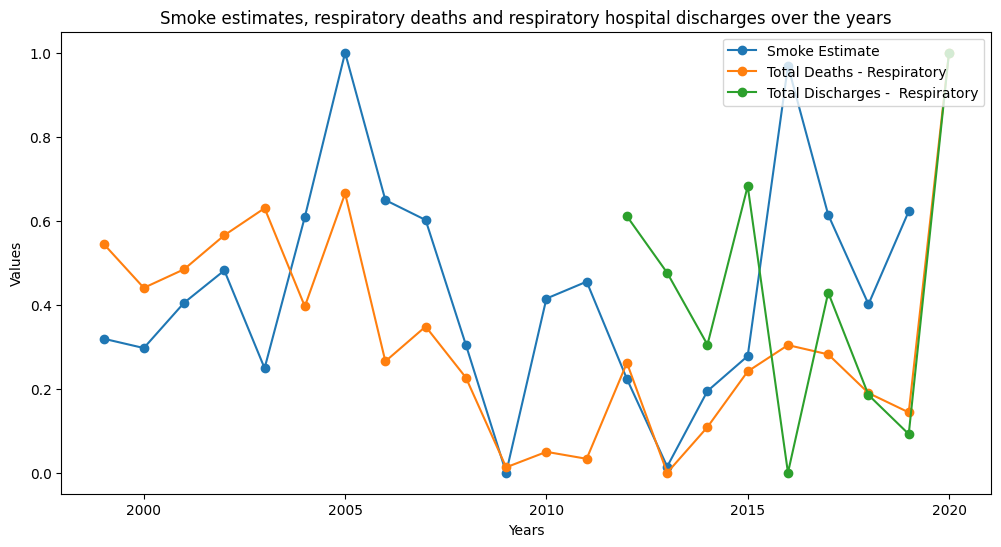

In [8]:
plt.figure(figsize=(12,6))

# plt.plot(yearly_aqi_weighted_avg["year"],yearly_aqi_weighted_avg["weighted_avg_aqi"] ,  label="AQI estimate")
plt.plot(health_and_smoke_data_scaled["Fire_Year"], health_and_smoke_data_scaled["Smoke Estimate_scaled"],  label = "Smoke Estimate", marker='o')
plt.plot(health_and_smoke_data_scaled["Year"],health_and_smoke_data_scaled["Respiratory Diseases_scaled"] , label="Total Deaths - Respiratory", marker='o')
plt.plot(health_and_smoke_data_scaled["Year_right"],health_and_smoke_data_scaled["Discharges_scaled"] , label="Total Discharges -  Respiratory", marker='o')

plt.legend(loc="upper right")

# Set the X-axis and Y axis labels, along with the title of the plot.
plt.xlabel('Years')
plt.ylabel('Values')

plt.title('Smoke estimates, respiratory deaths and respiratory hospital discharges over the years')
plt.savefig("generated_plots/smokeestimate_death_discharge.png", bbox_inches='tight') 

plt.show()


A few key observations from the graph:

- The peaks in smoke estimates and total deaths occur in similar years.
- There is a noticeable spike in both deaths and hospital discharges in 2020, likely due to COVID-19.

Since the trend in 2020 is unrelated to wildfire smoke, we will exclude that data from our analysis.

In [9]:
health_and_smoke_data_1999_2019 = (
    health_and_smoke_data
    .filter(
        pl.col("Year").is_between(1999, 2019)
    )
)
health_and_smoke_data_1999_2019

Year,Asthma,Lung cancer,Pneumonia,Colon cancer,COPD,Respiratory Diseases,Cancer,Total Deaths,Year_right,Discharges,Fire_Year,smoke_estimate,Smoke Estimate
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64
1999,23,282,522,81,466,1011,363,1374,null,null,1999,39.125304,30.15569
2000,20,285,472,80,462,954,365,1319,null,null,2000,30.15569,29.534159
2001,12,304,460,81,506,978,385,1363,null,null,2001,29.534159,32.537952
2002,25,334,484,80,513,1022,414,1436,null,null,2002,32.537952,34.685307
2003,17,291,514,68,526,1057,359,1416,null,null,2003,34.685307,28.196068
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,28,275,216,84,602,846,359,1205,2015,5727,2015,26.679641,29.003212
2016,36,239,214,72,630,880,311,1191,2016,5089,2016,29.003212,48.263021
2017,38,226,235,78,595,868,304,1172,2017,5490,2017,48.263021,38.374925


Next, let's analyze the individual fields and examine the correlations between them. To facilitate this, I've created a helper function that takes the dataframe and columns of interest as input and performs the following tasks:

- Scales the selected fields to a range of 0-1 and visualizes them on a graph.
- Calculates the Pearson correlation coefficient between the two variables.

In [10]:
def analyse_fields(df, variable_1, variable_2):

    df_scaled = scale_columns(df, [variable_1, variable_2])

    # plot graph
    plt.figure(figsize=(12,6))

    plt.plot(df_scaled["Year"], df_scaled[variable_1 + "_scaled"],  label =  variable_1, marker='o')
    plt.plot(df_scaled["Year"], df_scaled[variable_2 + "_scaled"],  label =  variable_2, marker='o')

    plt.legend(loc="upper right")

    # Set the X-axis and Y axis labels, along with the title of the plot.
    plt.xlabel('Years')
    plt.ylabel('Scaled value')
    
    # comparing variable_1 and variable_2
    correlation, p_value = pearsonr(df[variable_1], df[variable_2])

    # Display the correlation
    print(f"Pearson correlation coefficient - {variable_1} and {variable_2}: {correlation}")
    print(p_value)

Pearson correlation coefficient - Smoke Estimate and Total Deaths: 0.30890665777124116
0.17303777909662446


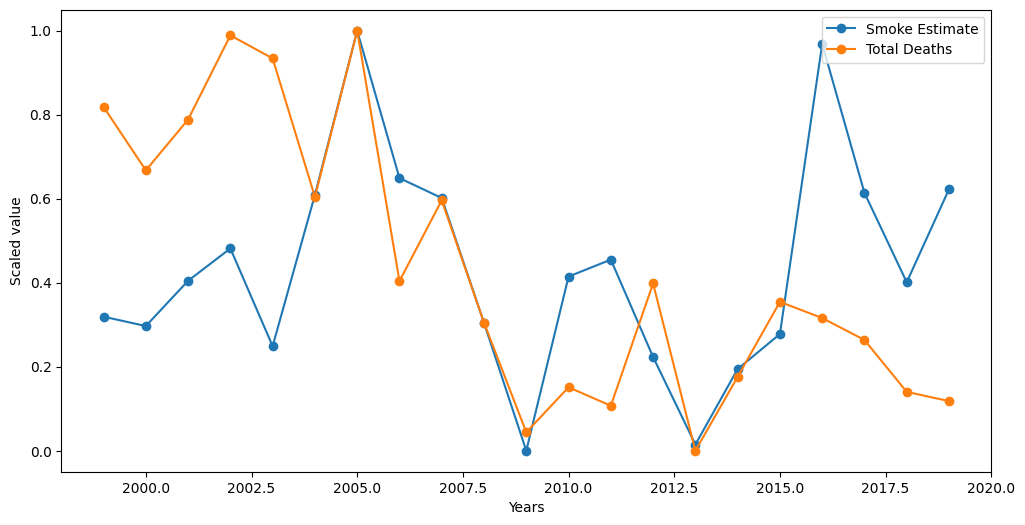

In [11]:
analyse_fields(health_and_smoke_data_1999_2019, "Smoke Estimate", "Total Deaths")

Pearson correlation coefficient - Smoke Estimate and Respiratory Diseases: 0.3939506613770177
0.07722383555601281
Pearson correlation coefficient - Smoke Estimate and Cancer: -0.2528944839122573
0.2687068018017689


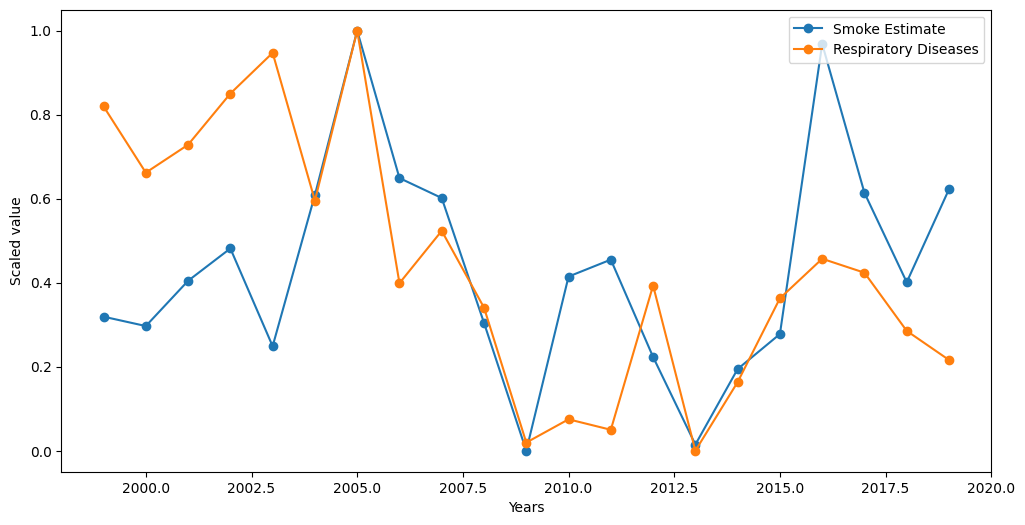

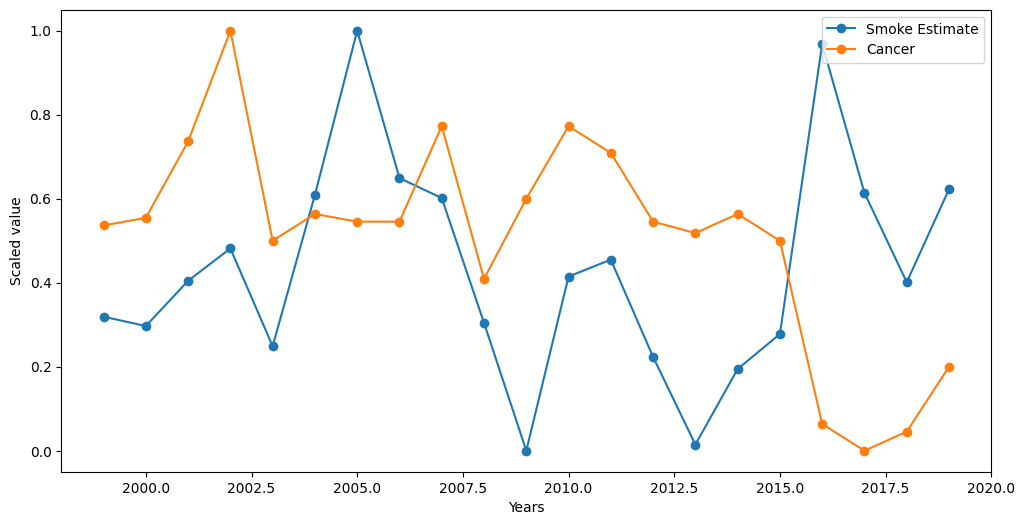

In [12]:
analyse_fields(health_and_smoke_data_1999_2019, "Smoke Estimate", "Respiratory Diseases")
analyse_fields(health_and_smoke_data_1999_2019, "Smoke Estimate", "Cancer")

We notice a moderate positive correlation between smoke estimates and deaths due respiratory diseases. Interestingly, we notice a negative correlation between smoke estimates and deaths due to cancers.

Lets proceed to analyse the correlation of smoke with deaths due to specific respiratory diseases

Pearson correlation coefficient - Smoke Estimate and Asthma: 0.49375807114893666
0.02291587549694834
Pearson correlation coefficient - Smoke Estimate and COPD: 0.2726758032061996
0.2317473940658623
Pearson correlation coefficient - Smoke Estimate and Pneumonia: 0.21232658081745054
0.35547608550710735


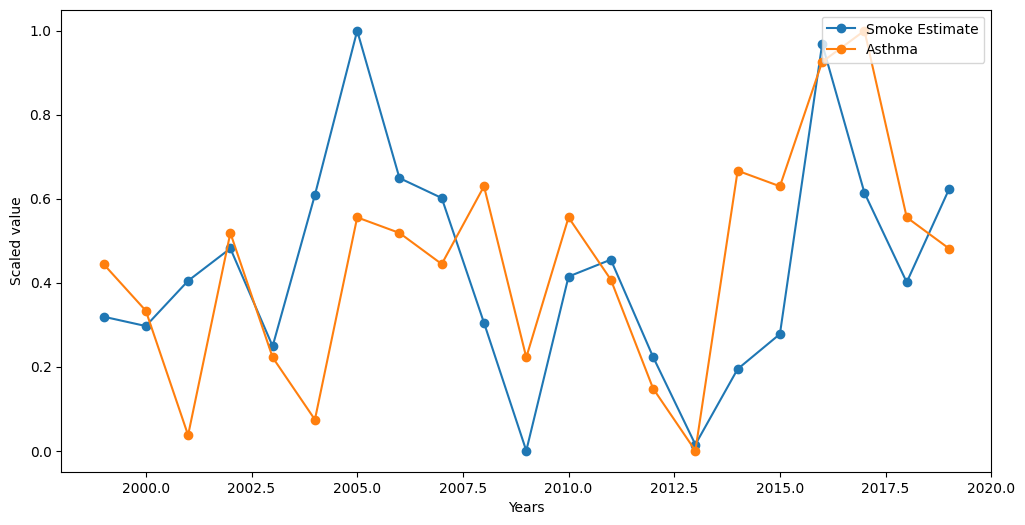

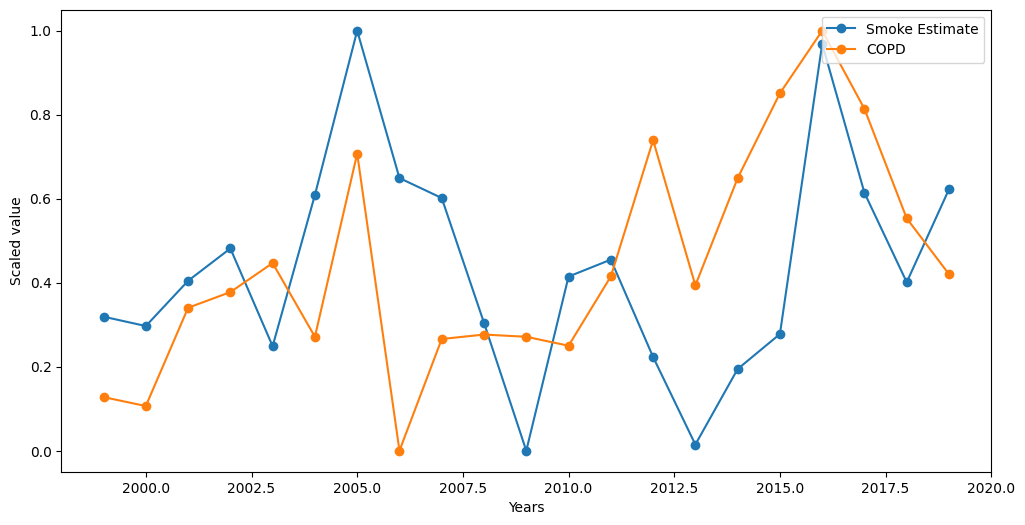

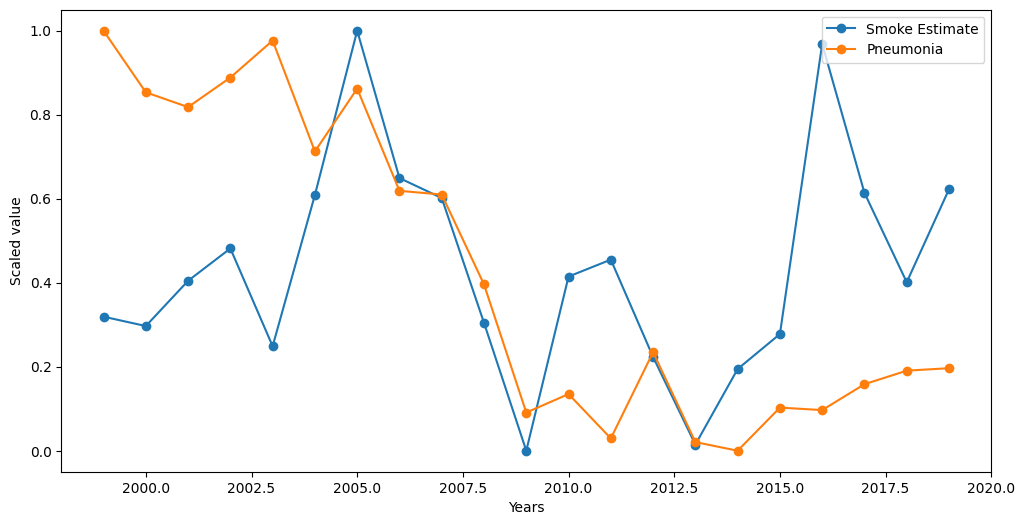

In [13]:
analyse_fields(health_and_smoke_data_1999_2019,"Smoke Estimate", "Asthma")
analyse_fields(health_and_smoke_data_1999_2019, "Smoke Estimate", "COPD")
analyse_fields(health_and_smoke_data_1999_2019, "Smoke Estimate", "Pneumonia")

An analysis of the relationship between smoke estimates and disease-specific mortality reveals that smoke estimates are more strongly correlated with deaths from respiratory diseases. Notably, there is a statistically significant positive correlation with deaths due to asthma.

Given the availability of hospitalization data for respiratory diseases, we next examine how smoke estimates correlate with hospital discharges.

Pearson correlation coefficient - Smoke Estimate and Discharges: -0.6983030376972583
0.054055195336096824


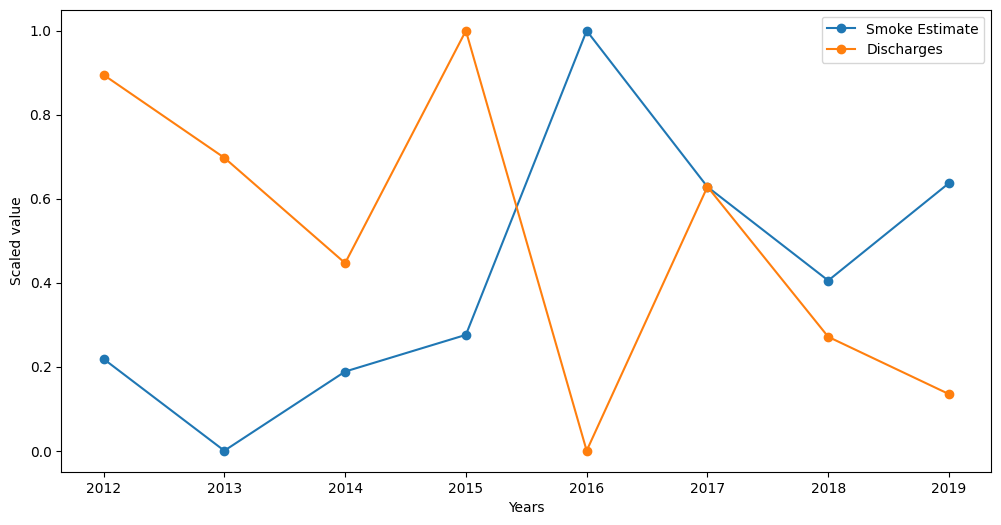

In [14]:
# lets analyse if smoke estimates are related to discharges

health_and_smoke_data_common = (
    health_and_smoke_data_1999_2019
    .filter(
        pl.col("Fire_Year") == pl.col("Year_right")
    )
)
analyse_fields(health_and_smoke_data_common, "Smoke Estimate", "Discharges")

Interestingly, the analysis reveals a negative correlation between smoke estimates and hospital discharges for respiratory diseases. This finding suggests that as wildfire smoke estimates increase, the number of recorded discharges tends to decrease.

### Predict Health Metrics

Now that we have analysed how smoke estimate correlates with each field, we see that information about smoke estimate can be used to predict health related information, i.e, number of deaths due to Asthma or number of discharges due to respiratory diseases.

For these predictions, I decided to used the SARIMAX model (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors), a robust time-series forecasting method. I chose this model due to its ability to address multiple critical aspects of our analysis:

* **Seasonal patterns**: SARIMAX effectively captures recurring trends and variations, such as seasonal spikes in smoke exposure and corresponding health outcomes.
* **Exogenous relationships**: It incorporates external variables—like smoke estimates—to enhance predictions of health metrics by modeling their influence on outcomes such as hospitalizations or respiratory illnesses.
* **Time-dependency**: The model accounts for the temporal nature of health impacts, ensuring that past trends and patterns inform future predictions.
* **Adaptability to trends**: SARIMAX can handle both short-term fluctuations, such as sudden spikes in smoke levels, and long-term trends, like gradual increases in wildfire activity or cumulative health effects.

Lets start with importing some packages we'll use for building a SARIMAX model for our usecase

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

I plan to develop multiple predictive models, with each model focusing on forecasting a specific health outcome influenced by wildfire smoke. This approach allows for tailored predictions and detailed insights into various aspects of public health. For this analysis, I am particularly interested in predicting the following endogenous variables:

* Deaths due to respiratory diseases: Mortality from conditions like COPD and bronchitis, reflecting the severe long-term impacts of smoke exposure.
* Deaths due to asthma: Fatalities from asthma, which is highly sensitive to poor air quality and smoke exposure.

*Since I have access to hospitalization data for a very few number of years, I do not expect a predictive model to be possible for forecasting the hospital discharge numbers*

For reusability, I've created few helper functions that is used to build the predictive model. 

In [16]:
def find_best_order(df, endog_column, exog_columns):

    train_data_df = df.filter(pl.col("Year") <= 2015).to_pandas()
    test_data_df = df.filter(pl.col("Year") > 2015).to_pandas()

    endog_train = train_data_df[endog_column]
    exog_train = train_data_df[exog_columns]
    endog_test = test_data_df[endog_column]
    exog_test = test_data_df[exog_columns]


    orders = [(1,1,1), (2,1,2), (1,1,2)]
    results = {}

    for order in orders:
        try:
            model = SARIMAX(endog_train, exog=exog_train, order=order).fit()
            pred = model.predict(start=len(endog_train),
                                end=len(endog_train) + len(endog_test) - 1,
                                exog=exog_test)
            mse = mean_squared_error(endog_test, pred)
            results[order] = mse
        except Exception as e:
            print(f"Error fitting model with order {order}: {e}")

    print("\nMSE for different orders:", results)

    # Use the best performing order for final model
    best_order = min(results.items(), key=lambda x: x[1])[0]
    print(f"\nBest performing order: {best_order}")

    return best_order
    

def build_model(df, endog_column, exog_columns):
    # Find the best order to train the model on the provided data
    best_order = find_best_order(df, endog_column, exog_columns)

    endog_data = df[endog_column].to_pandas()
    exog_data = df[exog_columns].to_pandas()

    # Build a model using the best order found and train it on the relevant data
    model= SARIMAX(endog=endog_data, exog=exog_data, order=best_order).fit()

    # Summarize the model results
    print(model.summary())

    # Plot diagnostics
    model.plot_diagnostics(figsize=(12, 8))
    plt.show()
    
    return model


def predict_values(model, future_df, exog_columns):
    forecasted_data = model.get_forecast(steps = len(future_df), exog=future_df[exog_columns]) 
    forecasted_values  = forecasted_data.predicted_mean
    forecasted_conf_int = forecasted_data.conf_int(alpha=0.05)

    # Combine predictions into a DataFrame
    predicted_df = pd.DataFrame({
        'Year': range(2020,2051),
        'Predicted_Value': forecasted_values,
    })

    return predicted_df, forecasted_conf_int

def plot_prediction(df, predicted_df, forecasted_conf_int,  endog_column):

    endog_column = endog_column[0]
    plt.figure(figsize=(12, 6))

    # Plot historical data
    plt.plot(df["Year"], df[endog_column], label='Historic Data')

    # Plot forecast
    plt.plot(predicted_df["Year"], predicted_df["Predicted_Value"], color='r', label='Predicted Data')
    plt.fill_between(predicted_df["Year"],
                    forecasted_conf_int.iloc[:, 0],
                    forecasted_conf_int.iloc[:, 1],
                    color='r', alpha=0.1)

    plt.title(f'{endog_column} Forecast using Smoke estimates')
    plt.legend()
    plt.savefig(f"generated_plots/forecasted_deaths_{endog_column}.png", bbox_inches='tight') 

    plt.show()

Since the analysis showed minimal correlation between smoke estimates and cancer-related deaths, it’s more promising to focus on predicting deaths caused by respiratory diseases. To proceed with this prediction, we will leverage the smoke estimates that were forecasted in part 1 of this project.

Lets start with loading the smoke estimates forecasted for the years 2020-2050

In [17]:
future_smoke_estimates = pd.read_csv("generated_files/intermediate/smoke_estimate_predictions_2020_2050_SARIMAX.csv")
exog_columns = ["Smoke Estimate"]

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.42577D+00    |proj g|=  2.52893D-02

At iterate    5    f=  5.42035D+00    |proj g|=  3.82647D-02

At iterate   10    f=  5.41563D+00    |proj g|=  1.76170D-03

At iterate   15    f=  5.41130D+00    |proj g|=  2.27780D-02

At iterate   20    f=  5.40948D+00    |proj g|=  1.00187D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   1.870D-05   5.409D+00
  F =   5.4094832837200766     

CONVERG

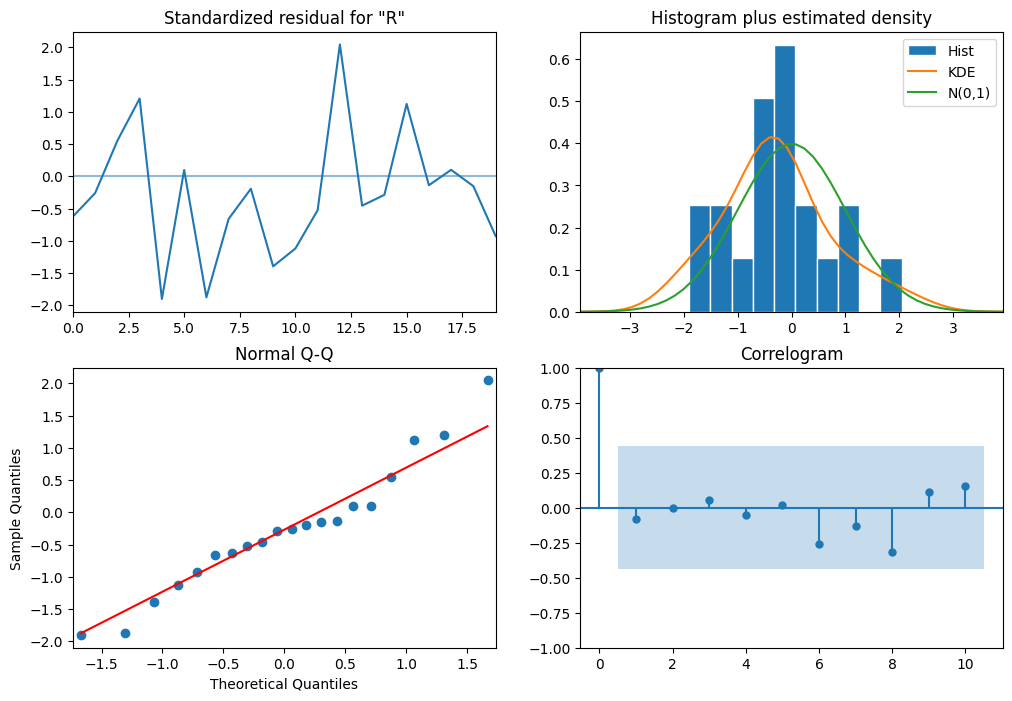

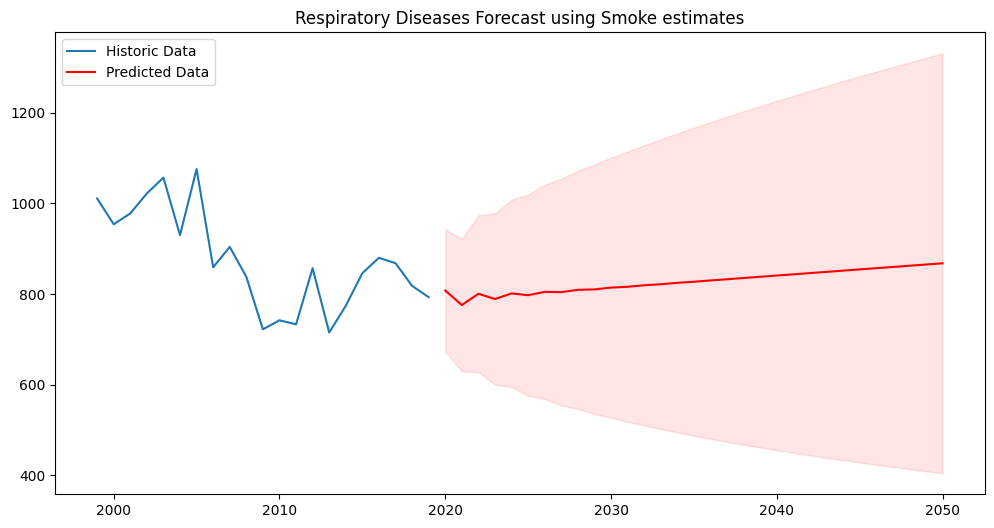

In [18]:
# predicting respiratory deaths using smoke estimates

endog_column = ["Respiratory Diseases"]

model = build_model(health_and_smoke_data_1999_2019, endog_column, exog_columns)
predicted_df, forecasted_conf_int = predict_values(model, future_df=future_smoke_estimates, exog_columns=exog_columns)

plot_prediction(health_and_smoke_data_1999_2019, predicted_df, forecasted_conf_int, endog_column)

The SARIMAX model results indicate a moderate fit for predicting the relationship between smoke estimates and deaths due to respiratory diseases. Key findings include:  

- **Smoke Estimate Coefficient:** The coefficient for smoke estimates is 4.2188, suggesting a positive relationship between smoke levels and respiratory deaths. However, the p-value of 0.104 indicates this relationship is not statistically significant at the conventional 5% level, though it approaches significance.  
- **Autoregressive (AR) and Moving Average (MA) Terms:** The AR(1) coefficient (-0.4585) and MA(1) coefficient (-0.1195) indicate slight dynamics in the data but are not statistically significant, with p-values of 0.245 and 0.771, respectively.  
- **Variance (sigma2):** The estimated variance of the error term (4733.5761) is statistically significant (p-value = 0.015), implying notable variability in the data that the model captures.  
- **Goodness of Fit:** Metrics such as AIC (234.310) and BIC (238.293) suggest room for improvement in the model's fit. The Ljung-Box test (Prob(Q) = 0.69) indicates no significant autocorrelation in residuals.  
- **Residual Analysis:** The skewness (0.45) and kurtosis (3.14) suggest residuals are reasonably symmetric and near-normal, supported by the Jarque-Bera test (Prob(JB) = 0.71).  

Overall, while the model captures some variability in the relationship between wildfire smoke and respiratory deaths, the lack of statistical significance for key predictors indicates the need for additional data or model refinement to better capture the underlying dynamics.

Now, let's shift our focus to building a prediction model specifically for forecasting deaths due to asthma, which, based on our earlier analysis, showed the strongest correlation with smoke estimates among respiratory diseases.

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-pac

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12306D+00    |proj g|=  1.23520D-01

At iterate    5    f=  3.05079D+00    |proj g|=  2.76669D-02

At iterate   10    f=  3.04492D+00    |proj g|=  3.73032D-03

At iterate   15    f=  3.04483D+00    |proj g|=  1.00556D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     19      1     0     0   3.631D-06   3.045D+00
  F =   3.0448338035427609     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

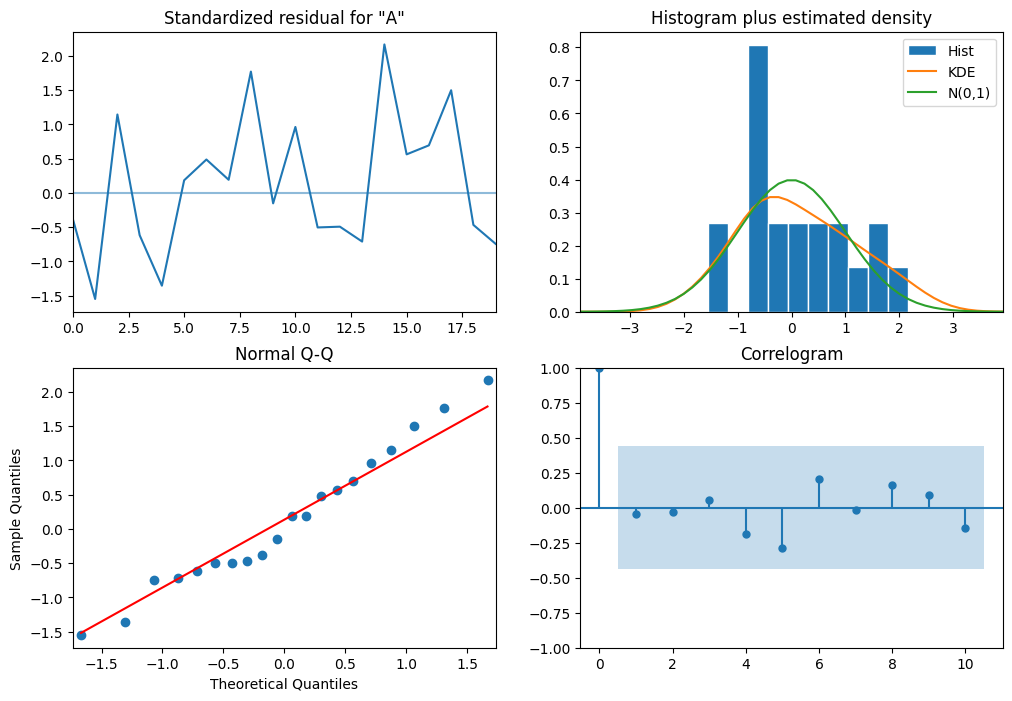

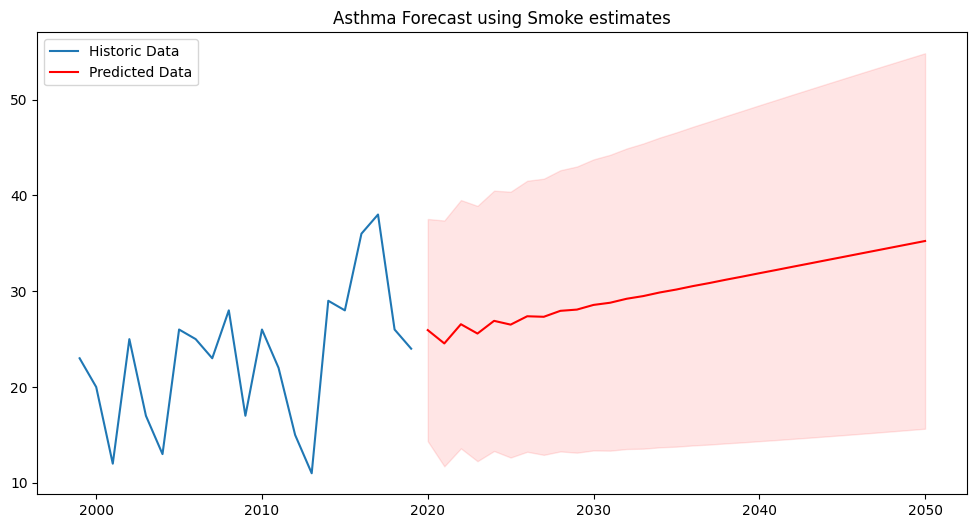

In [19]:
# predicting asthma deaths using smoke estimates

endog_column = ["Asthma"]

model = build_model(health_and_smoke_data_1999_2019, endog_column, exog_columns)
predicted_df, forecasted_conf_int = predict_values(model, future_df=future_smoke_estimates, exog_columns=exog_columns)

plot_prediction(health_and_smoke_data_1999_2019, predicted_df, forecasted_conf_int, endog_column)

The SARIMAX model results for predicting asthma-related outcomes provide insights into the relationship between wildfire smoke and asthma impacts. Key observations include:  

- **Smoke Estimate Coefficient:** The coefficient for smoke estimates is 0.5240, indicating a positive relationship between smoke exposure and asthma-related outcomes. However, with a p-value of 0.186, this relationship is not statistically significant, suggesting limited evidence to conclusively link smoke estimates to asthma impacts in this model.  
- **Autoregressive (AR) and Moving Average (MA) Terms:** The AR(1) coefficient (-0.3424) and MA(1) and MA(2) coefficients (-0.1847 and -0.4949, respectively) are not statistically significant, with high p-values (0.719, 0.798, and 0.451). This indicates that temporal dynamics in the data are not strongly captured by these components.  
- **Variance (sigma2):** The estimated variance (34.9955) is marginally significant, with a p-value of 0.055, suggesting the model captures some variability in asthma-related outcomes but leaves room for improvement.  
- **Goodness of Fit:** The AIC (138.702) and BIC (143.681) suggest a modest fit, with potential for refinement. The Ljung-Box test (Prob(Q) = 0.83) shows no significant autocorrelation in the residuals.  
- **Residual Analysis:** The skewness (0.34) and kurtosis (2.30) imply residuals are reasonably symmetric and close to normal. This is supported by the Jarque-Bera test (Prob(JB) = 0.67), which indicates no major deviation from normality.  

In summary, while the model suggests a potential positive relationship between wildfire smoke and asthma-related outcomes, the lack of statistical significance for key parameters indicates the results are inconclusive. Additional data or alternative modeling approaches may be needed to clarify this relationship.